In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# training & test 이미지 다운로드(제 깃허브에 올렸습니다)
!git clone https://github.com/ldh-Hoon/raw_image.git

Cloning into 'raw_image'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (30/30), 3.95 MiB | 13.76 MiB/s, done.


# 함수 및 상수

In [3]:
import math #sqrt 사용을 위함
import random # 랜덤 사용
import os # 올바른 경로로 파일 저장을 위함

import matplotlib.pyplot as plt # 그래프 시각화를 위함


In [4]:
training_path = "./raw_image/training"
save_path = "/content/drive/MyDrive/Colab Notebooks/2024_1학기_멀티미디어설계"
number_of_images = 19

# 단일 실행 테스트용 N, K
K = 4
N = 4

WIDTH = 512
HEIGHT = 512

In [5]:
# 거리 구하는 함수
# 속도를 위해 제곱근 연산을 생략했습니다
def get_distance(A, B):
    dist = 0.0
    for i in range(len(A)):
        dist += (B[i] - A[i])*(B[i] - A[i])
    #dist = math.sqrt(dist)
    return dist

In [6]:
# 이미지 로드
def load_training_images():
    images = []
    for index in range(number_of_images):
        with open(f"{training_path}/I{index}.img", "rb") as f:
            content = f.read()
        images.append(content)
    return images

In [7]:
# k 크기로 자르기
def split_images(images, kk):
    training_data = []
    k = int(math.sqrt(kk))
    for image in images:
        y = 0
        while(y < HEIGHT):
            x = 0
            while(x < WIDTH):
                temp = []
                for dy in range(k):
                    for dx in range(k):
                        if (y+dy) >= HEIGHT or (x+dx) >= WIDTH:
                            break
                        temp.append(int(image[(y+dy)*HEIGHT + (x+dx)]))

                training_data.append(temp)
                x += k
            y += k
    return training_data

In [8]:
# 초기화 방법 세가지 구현

# 랜덤 초기화
def make_random_center(n, k):
    output = []
    for i in range(n):
        temp = []
        for j in range(k):
            temp.append(random.uniform(0, 256))
        output.append(temp)
    return output

# 랜덤 샘플링 초기화(매번 기존 점보다 가장 먼 초기점을 sample_num중에서 선택)
def make_far_center(n, k, sample_num=200):
    output = []
    S = []
    for i in range(sample_num):
        temp = []
        for j in range(k):
            temp.append(random.uniform(0, 256))
        S.append(temp)

    past_index = []
    past_max = []

    # 하나를 랜덤하게 고름
    past_index.append(random.randint(0, sample_num))
    output.append(S[past_index[0]])
    for index in range(n - 1):
        max_dist = 0
        max_index = 0
        dist = [0.0 for _ in range(sample_num)]
        for i in range(0, index + 1):
            for j in range(sample_num):
                dist[j] += get_distance(output[i], S[j])
        for j in range(sample_num):
            if dist[j] > max_dist:
                if not j in past_index and not max_dist in past_max:
                    max_dist = dist[j]
                    max_index = j
                    past_max.append(max_dist)
                    past_index.append(j)
        output.append(S[max_index])
    return output

# 분할하기(분산이 가장 큰 축부터 분산과 epsilon에 비례하게 쪼갬)
def make_center_by_variance(data, n, k, epsilon):
    output = []
    total_mean = [0.0 for _ in range(k)]
    variance = [0 for _ in range(k)]
    max_var = [0 for _ in range(k)]
    max_var_index = [0 for _ in range(k)]
    for d in data:
        for i in range(k):
            total_mean[i] += d[i]
    for i in range(k):
        total_mean[i] /= len(data)
    for d in data:
        for i in range(k):
            variance[i] += (d[i]-total_mean[i])*(d[i]-total_mean[i])

    for i in range(k):
        variance[i] /= len(data)
        max_var[i] = variance[i]
        max_var_index[i] = i
    for i in range(k):
        for j in range(k):
            if max_var[max_var_index[j]] > max_var[max_var_index[i]]:
                if max_var_index[j] > max_var_index[i]:
                    temp = max_var_index[i]
                    max_var_index[i] = max_var_index[j]
                    max_var_index[j] = temp
    prev = []
    prev.append(total_mean)
    index = 0
    for i in range(int(math.log2(n))):
        temp = []
        for p in prev:
            for j in range(k):
                if j == max_var_index[index]:
                    a = []
                    b = []
                    for pp in p:
                        a.append(pp)
                        b.append(pp)
                    a[j] = a[j] + epsilon*((max_var[j]-max_var[max_var_index[k-1]])/(max_var[max_var_index[0]]-max_var[max_var_index[k-1]]))
                    b[j] = b[j] - epsilon*((max_var[j]-max_var[max_var_index[k-1]])/(max_var[max_var_index[0]]-max_var[max_var_index[k-1]]))
                    temp.append(a)
                    temp.append(b)

        prev = []
        for t in temp:
            prev.append(t)
        index += 1
        if index >= k:
            index = 0
    return prev, max_var_index

def make_add_center(prev, k, index, epsilon):
    output = []
    for p in prev:
        a = []
        b = []
        for pp in p:
            a.append(pp)
            b.append(pp)
        for j in range(k):
            if j == index:
                a[j] = a[j] + epsilon
                b[j] = b[j] - epsilon
                index += 1
                if index >= k:
                    index = 0
                    break
        output.append(a)
        output.append(b)
    return output

In [9]:
# 가장 가까운 중심으로 분류
def get_set(data, center):
    sets = dict()
    for i in range(len(center)):
        sets[i] = {
            'center':center[i],
            'data':[],
            'delta_center' : []
        }
    for index in range(len(data)):
        min_dist = -1
        c = 0
        for center_num in range(len(center)):
            d = get_distance(data[index], center[center_num])
            if min_dist==-1:
                min_dist = d
                c = center_num
            else:
                if min_dist > d:
                    min_dist = d
                    c = center_num
        sets[c]['data'].append(data[index])
    return sets

# 평균 중심 업데이트
def update_center(sets):
    k = len(sets[0]['center'])
    for s in sets:
        num = len(sets[s]['data'])
        if num > 0:
            center = [0 for _ in range(k)]
            for d in sets[s]['data']:
                for i in range(k):
                    center[i] += d[i]
            for i in range(k):
                center[i] /= num
                sets[s]['delta_center'].append(abs(sets[s]['center'][i]-center[i]))
            sets[s]['center'] = []
            for c in center:
                sets[s]['center'].append(c)

# 정보 확인용
def print_sets(sets):
    for s in sets:
        print(f"{s}번째 그룹")
        print("중심:", sets[s]['center'])
        print(f"{len(sets[s]['data'])}개")


In [10]:
# 중심값들을 저장
def save_centers(sets, k, n, center_type):
    if not os.path.isdir(f'{save_path}'):
        os.mkdir(f'{save_path}')
    if not os.path.isdir(f'{save_path}/{center_type}'):
        os.mkdir(f'{save_path}/{center_type}')
    with open(f"{save_path}/{center_type}/clustering_K{k}_N{n}.txt", "w") as f:
        for center in [sets[i]['center'] for i in range(len(sets))]:
            for c in center:
                f.write(str(c))
                f.write(' ')
            f.write('\n')
    print(f">>>{save_path}/{center_type}/clustering_K{k}_N{n}.txt 저장 완료")

In [11]:
# mse 계산 함수
def get_mse(data, centers):
    mse = 0
    for d in data:
        min_dist = -1
        c = 0
        for center_num in range(len(centers)):
            dist = get_distance(d, centers[center_num])
            if min_dist==-1:
                min_dist = dist
                c = center_num
            else:
                if min_dist > dist:
                    min_dist = dist
                    c = center_num
        sum = 0
        for i in range(len(d)):
            sum += (d[i] - centers[c][i])*(d[i] - centers[c][i])
        mse += sum
    mse /= len(data)
    return mse


In [12]:
def save_history(history, k, n, center_type):
    step = [x+1 for x in range(len(history))]
    change = [x for x in history]

    plt.figure(figsize=(10, 5))
    plt.plot(step, change, linestyle='-', color='blue')
    plt.title(f'{center_type},k:{k}, n:{n} history')
    plt.xlabel('step')
    plt.ylabel('changes')

    plt.savefig(f'{save_path}/{center_type}/history_clustering_K{k}_N{n}.png')
    plt.show()
def save_mse_history(mse_history, k, n, center_type):
    step = [x+1 for x in range(len(mse_history))]
    mse = [x for x in mse_history]

    plt.figure(figsize=(10, 5))
    plt.plot(step, mse, linestyle='-', color='blue')
    plt.title(f'{center_type},k:{k}, n:{n} MSE of training data\nbest:{mse[-1]}')
    plt.xlabel('step')
    plt.ylabel('MSE')

    plt.savefig(f'{save_path}/{center_type}/mse_history_clustering_K{k}_N{n}.png')
    plt.show()

In [13]:
def train(data, center_type, n, k, epsilon):
    print(f">>> k:{k}, n:{n}, {center_type} 학습 시작")
    centers = []
    if center_type == 'variance':
        centers, max_var_index = make_center_by_variance(data, n, k, epsilon)
    elif center_type == 'far':
        centers = make_far_center(n, k)
    elif center_type == 'random':
        centers = make_random_center(n, k)
    elif center_type == 'adding':
        centers, max_var_index = make_center_by_variance(data, 2, k, epsilon)

        sets = get_set(data, centers)

        mse_history = []
        history = []
        _n = 2
        i = 0
        while(1):
            print(f"split to {_n}")
            change = 1
            change_d = 1
            index = 0
            mse_d = 1
            flag = 0
            while(flag < 3 and index < 200):
                index += 1
                sets = get_set(data, [sets[i]['center'] for i in range(len(sets))])
                update_center(sets)
                #print_sets(sets)

                change = 0
                for s in sets:
                    for d in sets[s]['delta_center']:
                        change += d
                    if len(sets[s]['delta_center']) != 0:
                        change /= len(sets[s]['delta_center'])
                print(f"{index}번째 평균 중심 이동:{change}")
                if index > 3 and change < 0.0001:
                    flag += 1
                history.append(change)
                mse_history.append(get_mse(data, [sets[i]['center'] for i in range(len(sets))]))

            sets = get_set(data, [sets[i]['center'] for i in range(len(sets))])
            print(f"총 {index}번 업데이트")
            #print_sets(sets)
            save_centers(sets, k, _n, center_type)

            _n *= 2
            if _n > n:
                break
            else:
                mse_d = 1
                centers = make_add_center([sets[i]['center'] for i in range(len(sets))], k, i, epsilon)
                sets = get_set(data, centers)
                i += 1
                if i >= k:
                    i = 0

        return sets, history, mse_history

    sets = get_set(data, centers)

    mse_history = []
    history = []
    change = 1
    change_d = 1
    mse_d = 1
    index = 0
    flag = 0
    while(flag < 3 and index < 200):
        index += 1
        sets = get_set(data, [sets[i]['center'] for i in range(len(sets))])
        update_center(sets)

        change = 0
        for s in sets:
            for d in sets[s]['delta_center']:
                change += d
            if len(sets[s]['delta_center']) != 0:
                change /= len(sets[s]['delta_center'])
        #print(f"{index}번째 평균 중심 이동:{change}")
        if index > 3 and change < 0.0001:
            flag += 1
        history.append(change)
        mse_history.append(get_mse(data, [sets[i]['center'] for i in range(len(sets))]))

    sets = get_set(data, [sets[i]['center'] for i in range(len(sets))])
    print(f"총 {index}번 업데이트")
    #print_sets(sets)
    save_centers(sets, k, n, center_type)
    return sets, history, mse_history

# 단일 실행 테스트

In [14]:
images = load_training_images()
train_data = split_images(images, K)
print(f"데이터 총 개수 : {len(train_data)}, 차원 : {len(train_data[0])}")

데이터 총 개수 : 311296, 차원 : 16


In [ ]:
sets, history, mse_history = train(train_data, 'random', N, K, 0.01)

>>> k:16, n:4, random 학습 시작
총 24번 업데이트
>>>/content/drive/MyDrive/Colab Notebooks/2024_1학기_멀티미디어설계/random/clustering_K16_N4.txt 저장 완료


In [ ]:
# 저장
save_centers(sets, K, N, 'random')

# train 데이터에 대한 mse
mse_history[-1]

>>>/content/drive/MyDrive/Colab Notebooks/2024_1학기_멀티미디어설계/random/clustering_K16_N4.txt 저장 완료


7665.741067430817

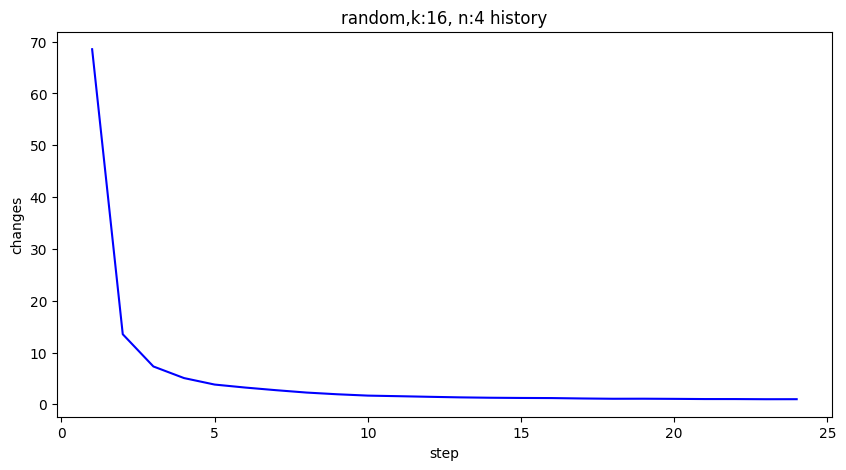

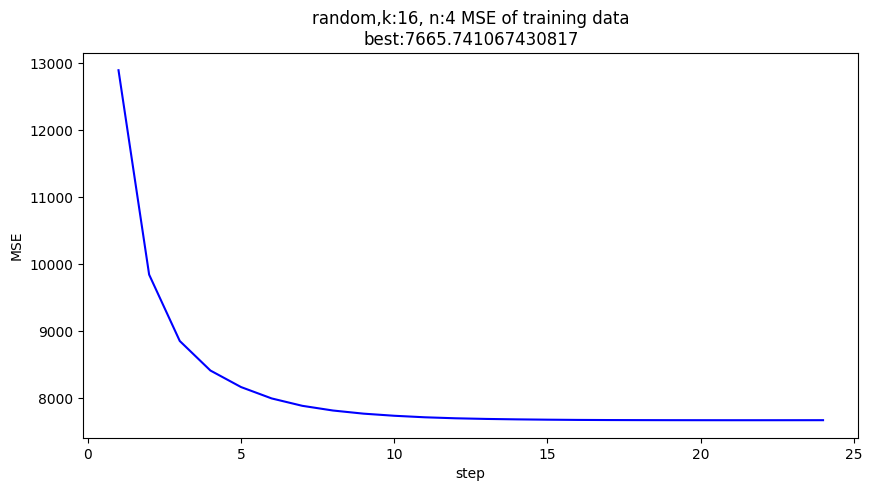

In [ ]:
save_history(history, K, N, 'random')
save_mse_history(mse_history, K, N, 'random')

# 다회 시행(멀티프로세싱, 4가지 초기화)

제 노트북이나 무료 colab에서는 너무 느려서 colab pro의 TPUv2(96개 코어)를 사용해
위 코드를 병렬처리하도록 했습니다

실행 시 사용 가능한 코어 전부에 작업을 할당합니다

In [ ]:
import multiprocessing as mp

print(f"사용 가능한 cpu core {mp.cpu_count()}개")

!head /proc/cpuinfo

사용 가능한 cpu core 96개
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.206
cache size	: 39424 KB
physical id	: 0


In [ ]:
from multiprocessing import Pool

# 전체 실행 코드

def train_and_save(params):
    train_data, center_type, n, k = params
    if center_type != 'adding' or n == 128:
        sets, history, mse_history = train(train_data, center_type, n, k, 0.0001)

        save_centers(sets, k, n, center_type)

        print(f"MSE for {center_type}, n={n}, k={k}: {mse_history[-1]}")

        save_history(history, k, n, center_type)
        save_mse_history(mse_history, k, n, center_type)

def main():
    images = load_training_images()
    tasks = []
    total_data = []
    index = 0
    for k in [4, 16, 64]:
        total_data.append(split_images(images, k))
        print(f"데이터 총 개수 : {len(total_data[index])}, 차원 : {len(total_data[index][0])}")

        for center_type in ['far', 'random', 'variance', 'adding']: # ['far', 'random', 'variance', 'adding']
            if center_type != 'adding':
                for n in [4, 8, 16, 32, 64, 128]:
                    tasks.append((total_data[index], center_type, n, k))
            else:
                tasks.append((total_data[index], center_type, 128, k))
        index += 1

    with Pool(processes=mp.cpu_count()) as pool:
        pool.map(train_and_save, tasks)

if __name__ == "__main__":
    main()


# 멀티프로세싱(계산 과정 병렬처리)

중심을 분할해가며 계산하는 초기화 방식(adding)만 따로 빠르게 진행하기 위해
관련 함수를 멀티프로세싱 처리한 코드입니다.

adding k= 4, 16, 64만 빠르게 계산합니다

In [14]:
from multiprocessing import Pool
import multiprocessing as mp

# 데이터 분할 함수
def chunkify(data, num_chunks):
    for i in range(0, len(data), num_chunks):
        if i + num_chunks >= len(data):
            yield data[i:]
        yield data[i:i + num_chunks]

In [15]:

def get_set_sub(data, center):
    sets = dict()
    for i in range(len(center)):
        sets[i] = {
            'center':center[i],
            'data':[],
            'delta_center' : []
        }
    for index in range(len(data)):
        min_dist = -1
        c = 0
        for center_num in range(len(center)):
            d = get_distance(data[index], center[center_num])
            if min_dist==-1:
                min_dist = d
                c = center_num
            else:
                if min_dist > d:
                    min_dist = d
                    c = center_num
        sets[c]['data'].append(data[index])
    return sets

def get_set(data, center, num_processes=mp.cpu_count()):
    pool = Pool(processes=num_processes)
    data_chunks = list(chunkify(data, 1+len(data) // num_processes))
    results = [pool.apply_async(get_set_sub, args=(chunk, center)) for chunk in data_chunks]
    pool.close()
    pool.join()

    sets = dict()
    for i in range(len(center)):
        sets[i] = {
            'center':center[i],
            'data':[],
            'delta_center' : []
        }
    for _result in results:
        result = _result.get()
        for r in result:
            if r in sets:
                for d in result[r]['data']:
                    sets[r]['data'].append(d)
    return sets

In [ ]:
for k in [4, 16, 64]:
    images = load_training_images()
    train_data = split_images(images, k)
    print(f"데이터 총 개수 : {len(train_data)}, 차원 : {len(train_data[0])}")
    for center_type in ['adding']:
        if center_type!= 'adding':
            for n in [4, 8, 16, 32, 64, 128]:
                sets, history, mse_history = train(train_data, center_type, n, k, 0.0001)

                # 저장
                save_centers(sets, k, n, center_type)

                save_history(history, k, n, center_type)
                save_mse_history(mse_history, k, n, center_type)
        else:
            sets, history, mse_history = train(train_data, center_type, 128, k, 0.0001)

            # 저장
            save_centers(sets, k, 128, center_type)

            save_history(history, k, 128, center_type)
            save_mse_history(mse_history, k, 128, center_type)
